In this project I'm trying to clean up the raw [US jobs on Monster.com](https://www.kaggle.com/code/ankkur13/perfect-dataset-to-get-the-hands-dirty/data) dataset and preprocess the data in order to prepare it for the future analysis. 
<br>
*Initially, this was an assignment for the Data Vizualization Methods course at ITMO University.*

# Exploration

In [4]:
import sys  

!{sys.executable} -m pip install --user missingno

  Using cached missingno-0.5.2-py3-none-any.whl (8.7 kB)

[notice] A new release of pip is available: 23.0 -> 23.1.2
[notice] To update, run: pip3.10 install --upgrade pip


In [5]:
# handy modules
import warnings
warnings.filterwarnings("ignore")

import re
import numpy as np
import pandas as pd
import missingno as msno
from matplotlib import pyplot as plt
import seaborn as sns

Let's take a brief look at the random data sample.

In [6]:
data = pd.read_csv("monster_com-job_sample.csv")
data.sample(10)

,country,country_code,date_added,has_expired,job_board,job_description,job_title,job_type,location,organization,page_url,salary,sector,uniq_id
6582,United States of America,US,NaN,No,jobs.monster.com,Job Description:Construction Dispatcher/Purcha...,Construction Dispatcher/Purchasing agent neede...,Full Time Employee,"Cypress, CA 90630",Other/Not Classified,http://jobview.monster.com/construction-dispat...,NaN,Experienced (Non-Manager),02ac09074672aff9aa90945919fda402
367,United States of America,US,NaN,No,jobs.monster.com,Advance Enterprise Inc. is currently hiring ca...,Entry Level Management-*Paid Training* Job in ...,Full Time Employee,"San Diego, CA 92121",RetailManagement Consulting ServicesOther/Not ...,http://jobview.monster.com/entry-level-managem...,NaN,Business/Strategic Management,ddcad1c2f24b14df09ab275f62f5813a
5504,United States of America,US,NaN,No,jobs.monster.com,Industry-Leading High Fashion House Seeking an...,Entry-Level Paralegal Job in New York,"Full Time , Employee","New York, NY",NaN,http://jobview.monster.com/Entry-Level-Paraleg...,"1.00 - 1,000,000.00 $ /year",NaN,6ba3d5f4f72d5ddc134fc11b3bf76c7f
10819,United States of America,US,NaN,No,jobs.monster.com,Job Description:Assistant Controller. Well est...,$ K Assistant Controller Job in Salt Lake City,Full Time,"Salt Lake City, UT 84119",Other/Not Classified,http://jobview.monster.com/45K-Assistant-Contr...,Up to $45000.00,Experienced (Non-Manager),1501129d38d4c00217bd6741fee7b47a
11024,United States of America,US,NaN,No,jobs.monster.com,This position is to serve as a Wind Tunnel Ins...,Instrumentation Engineer Job in Mountain View,NaN,Location:,NaN,http://jobview.monster.com/instrumentation-eng...,NaN,NaN,f946c1e47d0f80138caf42c669efd4ee
16582,United States of America,US,NaN,No,jobs.monster.com,Job Overview:The Asset Protection / Loss Preve...,Asset Protection / Loss Prevention Detective,Full Time Employee,"Columbus, OH",NaN,http://jobview.monster.com/asset-protection-lo...,NaN,Security/Protective Services,0cc991ceabebf9035192e9716132fc50
13268,United States of America,US,NaN,No,jobs.monster.com,"Job DescriptionAbsolute Adjusting, LLC is a gr...",Insurance Claims Adjuster and Auto Appraiser J...,Full Time,"Thief River Falls, MN 56701",Insurance,http://jobview.monster.com/Insurance-Claims-Ad...,"40,000.00 - 65,000.00 $ /yearRetirement, Healt...",Entry Level,5ef02bba9398ef9c6c18729a6efc424b
21250,United States of America,US,NaN,No,jobs.monster.com,Randstad Professionals is working with our cli...,Accounting Assoicate Job in Philadelphia body...,Full Time Temporary/Contract/Project,Philadelphia 19102,Accounting and Auditing Services,http://jobview.monster.com/Accounting-Assoicat...,NaN,Human Resources,a56f3408b542763beac19f40e5835639
2036,United States of America,US,NaN,No,jobs.monster.com,MarketPro has partnered with a leading Atlanta...,Media Relations Manager Job in Atlanta,Full Time,"Atlanta, GA 30309",NaN,http://jobview.monster.com/media-relations-man...,NaN,Experienced (Non-Manager),18c409e2ba3a234e3ca5d5a41afecb89
7357,United States of America,US,NaN,No,jobs.monster.com,Judge Healthcare is actively looking for a Dia...,Dialysis RN Job in Buckhead,"Full Time, Employee","Buckhead, GA",Healthcare Services,http://jobview.monster.com/dialysis-rn-job-buc...,NaN,Medical/Health,fc7aeb383aba6a0a01cff82d75ec897d


Here is my "table of contents" for this dataset:
<br>
a short description of columns + possible problems I see from the first glance.

In [7]:
description = ['Full country name', 'Country code (2-letter?)', 'Date of job listing publication', 'Expiration status (Yes/No)', 
               'Job board where job listing was published', 'Job description (text field)', 'Job title', 'Employment type + skill level', 
               'Location of the job', 'Sector company operates in', 'Link to the posting', 'Salary in $USD', 'Sector the job is in', 'Unique id']
problems = ["Nothing except 'United States of America'", 
            "Nothing except 'US'. Looks like an excessive duplication of country information", 
            'Data is primarily missing.', 
            "Nothing except 'No'", 
            "Nothing except 'jobs.monster.com'", 
            'No uniform description format. Values are large cluttered texts', 
            'Titles include a lot of data, that is supposed to be in other columns (e.g. location, job_type, sector)', 
            'Schedule type (Full Time/Part Time) and employment type (Employee/Temporary/Contract/Project) are mixed. Varied formatting', 
            'A lot of irrelevant data. Not all records are a full city + state + index combo', 
            'Many missing values', 'half of the URL is the same for all links, which seems excessive.', 
            'A lot of NaNs. Different time periods (hour/year). Sometimes thousands are missed.', 
            'Considerable amount of missing values', '-']

description_df = pd.DataFrame({'column_name': data.columns, 'description': description, 'problems': problems})

description_df

,column_name,description,problems
0,country,Full country name,Nothing except 'United States of America'
1,country_code,Country code (2-letter?),Nothing except 'US'. Looks like an excessive d...
2,date_added,Date of job listing publication,Data is primarily missing.
3,has_expired,Expiration status (Yes/No),Nothing except 'No'
4,job_board,Job board where job listing was published,Nothing except 'jobs.monster.com'
5,job_description,Job description (text field),No uniform description format. Values are larg...
6,job_title,Job title,"Titles include a lot of data, that is supposed..."
7,job_type,Employment type + skill level,Schedule type (Full Time/Part Time) and employ...
8,location,Location of the job,A lot of irrelevant data. Not all records are ...
9,organization,Sector company operates in,Many missing values


## Missing values

Let's see how many NaNs each column has.

In [8]:
data_nans_count = pd.DataFrame(data.isna().sum(), columns=['NaN_count'])
data_nans_count['NaN_%'] = data_nans_count['NaN_count'].apply(lambda x: round(x / data.shape[0] * 100, 1))
data_nans_count

,NaN_count,NaN_%
country,0,0.0
country_code,0,0.0
date_added,21878,99.4
has_expired,0,0.0
job_board,0,0.0
job_description,0,0.0
job_title,0,0.0
job_type,1628,7.4
location,0,0.0
organization,6867,31.2


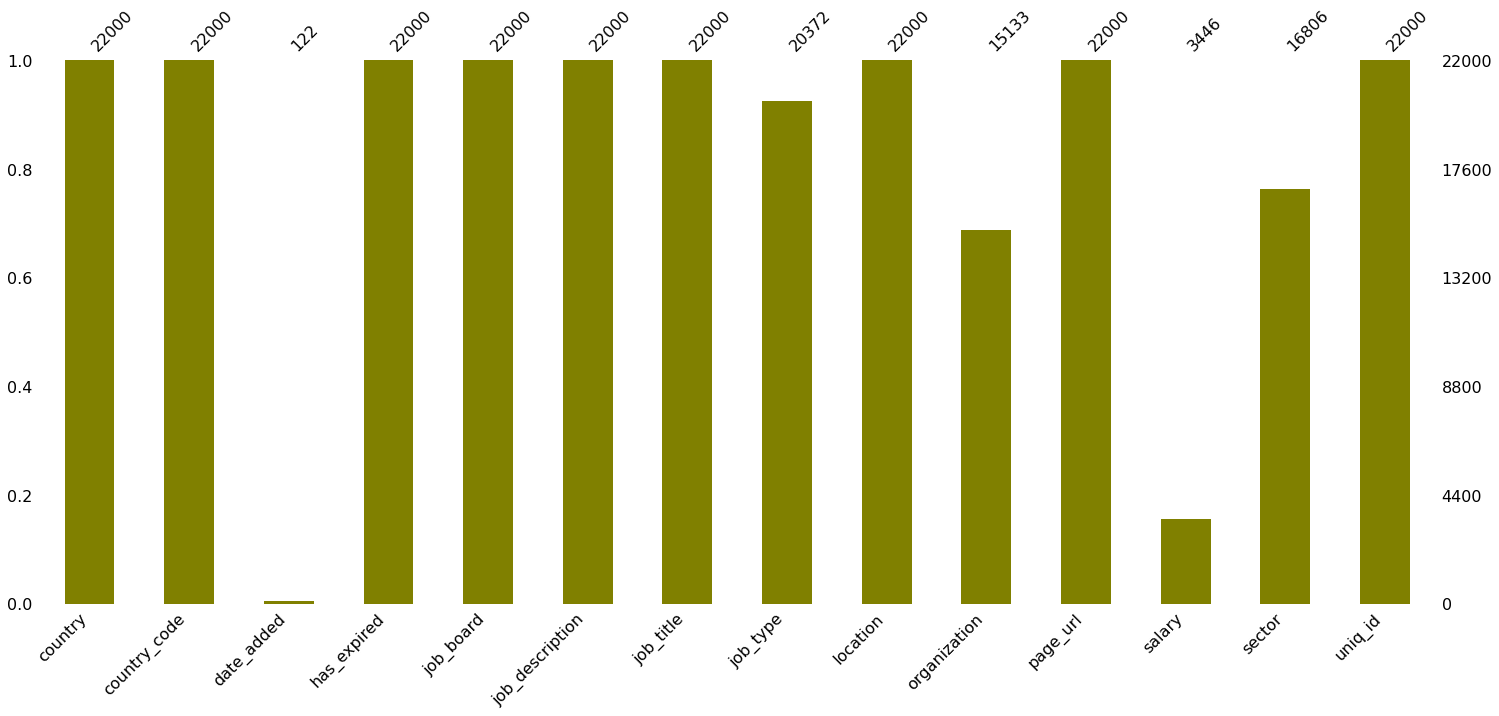

In [9]:
msno.bar(data, color="olive");

First things first, the **date_added** column is almost empty. **salary** column also primarily consists of missing values. Many gaps are in columns **organization**, **sector**, **job_type**. Other columns are filled to the brim.

Question: What will happen if we drop all rows that contain missing values?

In [10]:
nanless_data = data.dropna()
nanless_data 

,country,country_code,date_added,has_expired,job_board,job_description,job_title,job_type,location,organization,page_url,salary,sector,uniq_id
279,United States of America,US,6/10/2016,No,jobs.monster.com,"At American Family Insurance, we're firmly com...",Insurance Sales - Customer Service Job in Eden...,Full Time Employee,"Eden Prairie, MN 55344",Insurance,http://jobview.monster.com/insurance-sales-cus...,15.00 - 21.00 $ /hour,Accounting/Finance/Insurance,64a597e5dd17740aadf4b0e8047b51a5
7419,United States of America,US,4/27/2016,No,jobs.monster.com,A CUSTOMER SERVICE JOB … that might become a c...,Customer Service Representative Job in Las Vegas,Full Time Employee,"Las Vegas, NV 89129",Business Services - Other,http://jobview.local-jobs.monster.com/Customer...,$10.50+ /hour,Customer Support/Client Care,7baad80eae733c2518f0a500609c1e90
17048,United States of America,US,8/5/2016,No,jobs.monster.com,"At American Family Insurance, we're firmly com...",Licensed Insurance Sales Assistant (Customer S...,Full Time Employee,"Covington, GA",Insurance,http://jobview.monster.com/licensed-insurance-...,$10.50+ /hour,Sales/Retail/Business Development,c486cae7c4c1105a85e50448fb9c0dd0
17052,United States of America,US,8/2/2016,No,jobs.monster.com,"At American Family Insurance, we're firmly com...",Customer Service Agent / Insurance Sales Assis...,Full Time Employee,"Alpharetta, GA 30009",Insurance,http://jobview.monster.com/customer-service-ag...,11.00 - 15.00 $ /hour,Sales/Retail/Business Development,6ddfdf91eb991d9d31f3cd2ee4492eb9
18709,United States of America,US,3/11/2016,No,jobs.monster.com,There's No Place Like The Neighborhood!It's a ...,Restaurant Manager - Applebee's Parsippany,"Full Time, Employee","Parsippany, NJ 07054",Restaurant/Food Services,http://jobview.monster.com/Restaurant-Manager-...,50.00 - 65.00 $ /year,Food Services/Hospitality,4fb8c68e3b6efcec902801a96f2cb004


Answer: If we drop all rows with NaNs, we'll end up with 5 rows out of initial 22000.

Therefore, we won't be dropping all NaN-containing rows, because most of the valuable data would be lost.

## Irrelevant columns

Let's assess which columns should be kept and which can be deleted.

### 1. Single-value columns

In [11]:
data_unique_count = pd.DataFrame(data[['country', 'country_code', 'has_expired', 'job_board']].nunique(), 
                                 columns=['unique_count'])
data_unique_count

,unique_count
country,1
country_code,1
has_expired,1
job_board,1


So, the dataset has 4 columns that have one unique value, which means it is the same for all rows. This information can be useful for creating a clearer image of a dataset as a whole. In this case, our dataset is comprised of relevant job listings in the US from jobs.monster.com. There is no point in storing this data as a table columns -  mentioning it in the dataset description would be enough.

### 2. Duplicate columns





- Mentioned above columns **country** and **country_code** store the same information and are interchangable.
- Records in the **job_title** column frequently include the city name, which is already mentioned in the **location** column.

### 3. Irrelevant-value columns
- Unique identifier from the **uniq_id** column is only needed for differentiation between all records. However, it's possible for some identical rows to have different ids.
- **page_url** value is also unique for each row, but it is not really valuable for analysis as it carries no useful information (maybe, except for a job title inside the URL, but this info is already in the **job_title** column.
- Single-value columns are irrelevant as well (see pt. 1).

## Duplicate rows

In order to clearly identify each individual record, we need to choose an optimal set of columns as a composite primary key. 
<br>
What it means is that if two rows have the same values in these columns, they're considered duplicates.

In [12]:
print(f"Total: {data.shape[0]} rows")

Total: 22000 rows


In [13]:
key = ['job_title', 'location']
print(f"Unique combinations of columns {key}: {data.drop_duplicates(subset=key).shape[0]}")

Unique combinations of columns ['job_title', 'location']: 19876


In [14]:
key = ['job_title', 'job_type', 'location']
print(f"Unique combinations of columns {key}: {data.drop_duplicates(subset=key).shape[0]}")

Unique combinations of columns ['job_title', 'job_type', 'location']: 19963


In [15]:
key = ['job_title', 'organization', 'location']
print(f"Unique combinations of columns {key}: {data.drop_duplicates(subset=key).shape[0]}")

Unique combinations of columns ['job_title', 'organization', 'location']: 19963


In [16]:
key = ['job_title', 'job_type', 'organization', 'location']
print(f"Unique combinations of columns {key}: {data.drop_duplicates(subset=key).shape[0]}")

Unique combinations of columns ['job_title', 'job_type', 'organization', 'location']: 20006


In [17]:
key = ['job_title', 'job_type', 'organization', 'location', 'salary']
print(f"Unique combinations of columns {key}: {data.drop_duplicates(subset=key).shape[0]}")

Unique combinations of columns ['job_title', 'job_type', 'organization', 'location', 'salary']: 20046


In [18]:
key = ['job_title', 'job_type', 'organization', 'location', 'sector']
print(f"Unique combinations of columns {key}: {data.drop_duplicates(subset=key).shape[0]}")

Unique combinations of columns ['job_title', 'job_type', 'organization', 'location', 'sector']: 20041


Judging by the little experiment above, I think the optimal composite primary key is a combination of columns **job_title**, **job_type**, **organization**, **location**, **salary**. Such key results in relatively small data loss when dropping duplicates, while being composed of not so many columns.

So how much information would we lose if we drop duplicates using such primary key? 

Original dataset statistics

In [19]:
data.describe()

,country,country_code,date_added,has_expired,job_board,job_description,job_title,job_type,location,organization,page_url,salary,sector,uniq_id
count,22000,22000,122,22000,22000,22000,22000,20372,22000,15133,22000,3446,16806,22000
unique,1,1,78,1,1,18744,18759,39,8423,738,22000,1737,163,22000
top,United States of America,US,9/22/2016,No,jobs.monster.com,12N Horizontal Construction Engineers Job Desc...,Monster,Full Time,"Dallas, TX",Healthcare Services,http://jobview.monster.com/it-support-technici...,"40,000.00 - 100,000.00 $ /year",Experienced (Non-Manager),11d599f229a80023d2f40e7c52cd941e
freq,22000,22000,6,22000,22000,104,318,6757,646,1919,1,50,4594,1


Duplicate-dropped dataset statistics

In [20]:
key = ['job_title', 'job_type', 'organization', 'location', 'salary']
data.drop_duplicates(subset=key).describe()

,country,country_code,date_added,has_expired,job_board,job_description,job_title,job_type,location,organization,page_url,salary,sector,uniq_id
count,20046,20046,114,20046,20046,20046,20046,18555,20046,13636,20046,3268,15192,20046
unique,1,1,76,1,1,18059,18759,39,8423,738,20046,1737,162,20046
top,United States of America,US,5/26/2016,No,jobs.monster.com,12N Horizontal Construction Engineers Job Desc...,Monster,Full Time,"Dallas, TX",Healthcare Services,http://jobview.monster.com/it-support-technici...,"40,000.00 - 100,000.00 $ /year",Experienced (Non-Manager),11d599f229a80023d2f40e7c52cd941e
freq,20046,20046,4,20046,20046,93,293,6355,561,1700,1,50,4228,1


The resulting dataset has 1954 less rows. The most occurrent values in each column haven't changed.

# Preprocessing

## Deleting excess data

Dropping everything irrelevant we've found at the previous step.

In [21]:
# Keep a copy of the dataset to compare with the result later
from copy import deepcopy

data_copy = deepcopy(data)

In [22]:
# Drop columns with missing values
data.drop(columns="date_added", inplace=True)

In [23]:
# Drop irrelevant columns
data.drop(columns=["country",	"country_code",	"has_expired",	
                   "job_board", "page_url", "uniq_id"], inplace=True)

In [24]:
# Drop duplicates (rows)
key = ['job_title', 'job_type', 'organization', 'location', 'salary']
data.drop_duplicates(subset=key, inplace=True)

The resulting cleaned-up dataset statistics

In [25]:
data.describe()

,job_description,job_title,job_type,location,organization,salary,sector
count,20046,20046,18555,20046,13636,3268,15192
unique,18059,18759,39,8423,738,1737,162
top,12N Horizontal Construction Engineers Job Desc...,Monster,Full Time,"Dallas, TX",Healthcare Services,"40,000.00 - 100,000.00 $ /year",Experienced (Non-Manager)
freq,93,293,6355,561,1700,50,4228


In [26]:
print(f"Dataset shape: {data.shape[0]} rows, {data.shape[1]} columns")

Dataset shape: 20046 rows, 7 columns


## Location

To begin with, we determine which value formats are there in the **location** column.

In [27]:
# Assume that location cannot be longer than 6 words (helps to filter out job descriptions that accidentially got here)
data['location'] = data.location.apply(str.strip)
data = data[data.location.apply(lambda x: len(x.split())) < 6]

# Get rid of excess words and symbols
data['location'] = (data.location.apply(lambda x: x.replace('Address ', ''))
                                 .apply(lambda x: x.replace(' \xa0 ', ' '))
                                 .apply(lambda x: x.replace(' \xa0', ' '))
                                 .apply(lambda x: x.replace('\xa0', ' '))
                                 .apply(lambda x: x.replace(' , ', ', ').strip()))


list(data.sample(30).location.unique())

['Bowling Green, KY 42102',
 'Tucker, GA',
 'New York, NY 10017',
 'Madison, WI',
 'Colorado Springs, CO 80918',
 'Lakeway, TX 78734',
 'Los Angeles, CA',
 'Phone 330-618-9895 Fax 330-633-2059',
 'Jersey City, NJ 07097',
 'Sarasota, FL 34230',
 'California, CA',
 'Newark, NJ 07104',
 'Bowling Green, FL 33834',
 'Dallas, TX 75201',
 'Parsippany, NJ 07054',
 'Cincinnati, OH 45214',
 'AUSTIN, TX',
 'Plymouth, MN 55442',
 'Baton Rouge, LA',
 'Cincinnati, OH 45202',
 'Atlanta, GA 30354',
 'Houston, TX 77040',
 'Atlanta, GA',
 'Columbus, OH 43232',
 'Boston, MA 02210',
 'Boston, MA',
 'Chattanooga, TN',
 'Newton, NC 28658',
 'Oklahoma City, OK 73116']

There are many outliers such as telephone numbers, contact details, job titles etc. 
<br>
As for locations, I've found these main formats:
- state
- citySTATE
- city, state
- city, state postcode
- city postcode
- postcode

### Location RegEx
Creating regular exceptions for finding these formats

In [28]:
formats = ['state', 'citySTATE', 'city, state', 'city, state postcode', 'city postcode', 'postcode', 'others']
templates = ["^[A-Z]{2}$", 
             "^[A-Z][a-z\.\-'/ ]+( ?[A-Z][a-z\.\-'/]*){0,3}[A-Z]{2}$", 
             "^[A-Z][a-z\.\-'/ ]+( ?[A-Z][a-z\.\-'/]*){0,3}, [A-Z]{2}$", 
             "^[A-Z][a-z\.\-'/ ]+( ?[A-Z][a-z\.\-'/]*){0,3}, [A-Z]{2} [0-9]{4,5}$",
             "^[A-Z][a-z\.\-'/ ]+( ?[A-Z][a-z\.\-'/]*){0,3} [0-9]{4,5}$", 
             "^[0-9]{4,5}$"]
counts = []

In [29]:
# 1
format1 = data[data.location.str.match(templates[0])].location
counts.append(len(format1))
format1 

432      WI
433      CA
434      LA
436      KY
438      TN
         ..
998      CO
1005     MO
10495    MO
14049    TX
15331    MD
Name: location, Length: 171, dtype: object

In [30]:
# 2
format2 = data[data.location.str.match(templates[1])].location
counts.append(len(format2))
format2 

878            DallasTX
1313     IndianapolisIN
1771          AtlantaGA
1797          AtlantaGA
1800          AtlantaGA
              ...      
21049          BostonMA
21199      SwedesboroNJ
21201      Long BeachCA
21316        Chicago IL
21684        Chicago IL
Name: location, Length: 109, dtype: object

In [31]:
# 3
format3 = data[data.location.str.match(templates[2])].location
counts.append(len(format3))
format3

3                  Dixon, CA
4               Camphill, PA
5        Charlottesville, VA
9           Chesterfield, MO
11              Columbus, IN
                ...         
21976         Cincinnati, OH
21980         Cincinnati, OH
21981       West Chester, OH
21995         Cincinnati, OH
21999         Cincinnati, OH
Name: location, Length: 6118, dtype: object

In [32]:
# 4
format4 = data[data.location.str.match(templates[3])].location
counts.append(len(format4))
format4

0           Madison, WI 53702
1           Madison, WI 53708
7            Austin, TX 73301
8            Austin, TX 78746
10       Berryville, VA 22611
                 ...         
21993       Chicago, IL 60603
21994    Cincinnati, OH 45202
21996    Cincinnati, OH 45236
21997       Chicago, IL 60602
21998       Chicago, IL 60609
Name: location, Length: 10721, dtype: object

In [33]:
# 5
format5 = data[data.location.str.match(templates[4])].location
counts.append(len(format5))
format5

16           Wadesboro 28170
22            La Porte 46350
85            Columbus 68601
104          Galesburg 64101
108          Edinburgh 46124
                ...         
21040     Jacksonville 32256
21088    Oklahoma City 73115
21108         Columbus 43251
21250     Philadelphia 19102
21603       Cincinnati 45203
Name: location, Length: 297, dtype: object

In [34]:
# 6
format6 = data[data.location.str.match(templates[5])].location
counts.append(len(format6))
format6

175      46052
181      19904
220      49601
363      80498
456      15963
         ...  
20808    74074
20907    73044
20916    46131
21046    46140
21062    21502
Name: location, Length: 253, dtype: object

In [35]:
others = data.shape[0] - sum(counts)
counts.append(others)

<AxesSubplot:>

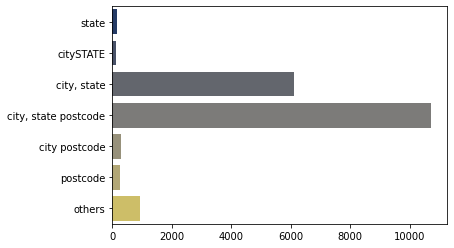

In [36]:
sns.barplot(x = counts, y = formats, orient = 'h', color = counts, palette = 'cividis')

Formats *city, state* and *city, state index* prevail. However, there are a lot of values that don't fit any format.

It makes sense to split the **location** column into three: **city**, **state**, **postcode** (in case of some data missing, fill with NaNs).

### Format
First, let's work with format-friendly data.

In [37]:
valid_location = data[data.location.str.match(f"({templates[0]})|({templates[1]})|({templates[2]})|({templates[3]})|({templates[4]})|({templates[5]})")]
invalid_location = data[~data.location.str.match(f"({templates[0]})|({templates[1]})|({templates[2]})|({templates[3]})|({templates[4]})|({templates[5]})")]

In [38]:
def split_location(x):
  if re.fullmatch(templates[0], x):
    return np.nan, x, np.nan
  if re.fullmatch(templates[1], x):
    return x[:-2], x[-2:], np.nan
  if re.fullmatch(templates[2], x):
    return x.split(', ')[0], x.split(', ')[1], np.nan
  if re.fullmatch(templates[3], x):
    return x.split(', ')[0], x.split(', ')[1].split()[0], x.split(', ')[1].split()[1]
  if re.fullmatch(templates[4], x):
    return x[:-6], np.nan, x[-5:]
  if re.fullmatch(templates[5], x):
    return np.nan, np.nan, x
  return np.nan, np.nan, np.nan
  

valid_location.insert(loc=3, column='city', value=valid_location.location.apply(lambda x: split_location(x)[0]))
valid_location.insert(loc=4, column='state', value=valid_location.location.apply(lambda x: split_location(x)[1]))
valid_location.insert(loc=5, column='postcode', value=valid_location.location.apply(lambda x: split_location(x)[2]))
valid_location.sample(10)

,job_description,job_title,job_type,city,state,postcode,location,organization,salary,sector
19696,Now Hiring Restaurant Manager professionals ac...,Restaurant Manager / General Manager Job in Sh...,Full Time Employee,Shreveport,LA,NaN,"Shreveport, LA",NaN,"30,000.00 - 60,000.00 $ /year",Food Services/Hospitality
4821,"Position Summary ""Together, we improve people'...",Bakery Sales Clerk (Part Time) - Upper Arlingt...,Full Time Employee,Columbus,OH,NaN,"Columbus, OH",Food and Beverage Production,NaN,Sales/Retail/Business Development
657,Senior Network Test Engineer Samsung Electroni...,Senior Network Test Engineer Job in Carrollton,Full Time,Carrollton,TX,75007,"Carrollton, TX 75007",Other/Not Classified,NaN,NaN
14171,SENIOR FINANCIAL ANALYST - FORTUNE 500!!!If yo...,SENIOR FINANCIAL ANALYST - FORTUNE ! Job in In...,Full Time,Indianapolis,IN,46201,"Indianapolis, IN 46201",All,"75,000.00 - 95,000.00 $ /yearTop benfits inclu...",Experienced (Non-Manager)
11119,Full-Time Financial Reporting-GL-MKE 6737 W. W...,Director of Financial Reporting Job in Milwaukee,Full Time Employee,Milwaukee,WI,53214,"Milwaukee, WI 53214",Healthcare Services Business Services - Other ...,NaN,Medical/Health
10626,"POSITION SUMMARY:Develop, implement and manage...",QUALITY MANAGER Job in Minneapolis,Full Time Employee,Minneapolis,MN,55438,"Minneapolis, MN 55438",Manufacturing - Other,NaN,Quality Assurance/Safety
5131,Position Summary Provide leadership in the Dai...,Dairy Lead (Full TIme) Grandview Market Distri...,Full Time Employee,Columbus,OH,NaN,"Columbus, OH",Food and Beverage Production,NaN,Marketing/Product
9663,Green America Recycling is seeking full time S...,Solid Waste Fuels Technician Job in Hannibal,Full Time,Hannibal,MO,63401,"Hannibal, MO 63401",Manufacturing - Other,NaN,Entry Level
13069,CenturyLink (NYSE: CTL) is a global communicat...,SR ENTERPRISE RELATIONSHIP MANAGER Job in Char...,Full Time Employee,Charlottesville,VA,22903,"Charlottesville, VA 22903",Business Services - Other,NaN,Project/Program Management
9189,Title: HVAC Service TechnicianCompany: E.M. Lo...,HVAC Service Technician Job in Woodbridge fun...,Full Time,Woodbridge,NaN,22191,Woodbridge 22191,All,NaN,Experienced (Non-Manager)


### Non-format
Secondly, non-format data.

In [39]:
invalid_location.sample(10)

,job_description,job_title,job_type,location,organization,salary,sector
2343,Report this job About the Job ProLogistix - a ...,ProLogistix Job Application for Staffing Perso...,"Full Time, Employee",Contact name Jenny Mason,Staffing/Employment Agencies,NaN,NaN
10560,Experis IT is partnering with a Fortune 100 co...,Mainframe QA Tester Job in Wilmington,Full Time Temporary/Contract/Project,Mainframe QA Tester,"Wilmington, DE 19803",NaN,Quality Assurance/Safety
1890,Report this job About the Job Position Informa...,American Income Life Job Application for Sales...,"Part Time, Temporary/Contract/Project",Phone 1-800-405-5591,All,NaN,NaN
4542,Description Quality Assurance Supervisor Disco...,Quality Assurance Supervisor Job in Chicago bo...,"Full Time, Employee",Chicago,Business Services - Other,NaN,Experienced (Non-Manager)
16514,RM Production Support (technical Architect) (5...,RM Production Support Analyst Job in Plano,Full Time Temporary/Contract/Project,RM Production Support Analyst,"Plano, TX",NaN,IT/Software Development
1762,"Experis, one of the nation's leading I.T. Staf...",Sr. Sales Recruiter Job in Sandy Springs,Full Time Temporary/Contract/Project,Sr. Sales Recruiter,"Sandy Springs, GA 30342",30.00 - 35.00 $ /hour,Human Resources
17318,You will be supporting the implementation of M...,WMS Developer Job in Irving,Full Time,Location:,Retail,NaN,IT/Software Development
20502,Your passion for care - it’s reasoning behind ...,function icims_stripIFrameParameter(url) { url...,NaN,US-MN-St. Paul,NaN,NaN,Patient Care Support/Nursing Assistant
2277,Report this job About the Job We are working o...,CyberCoders Job Application for Electrical Eng...,"Full Time, Employee",Contact name Leslie Vivian,Architectural and Design Services,NaN,NaN
21030,Report this job About the Job CAPE FEAR COMMUN...,Cape Fear Community College Job Application fo...,"Full Time, Employee",Phone (910) 362-7312,Education,NaN,NaN


Some additional formats:
- city
- state postcode
- postcode, state 
- CITY, state, postcode
- CITY, state
- CITY, state postcode
- city, state(Xx) postcode
- city, state(Xx), state(XX)
- city, state non-postcode-number
- ..., state

In [40]:
extra_templates = ["^[A-Z][a-z]+$", 
                   "^[A-Z]{2} [0-9]{4,5}$",
                   "^[0-9]{4,5}, [A-Z]{2}$",
                   "^[A-Z][a-z\.\-'/]+( ?[A-Z][a-z\.\-'/]*){0,3}, [A-Za-z ]+, [0-9]{4,5}$",
                   "^[A-Z ]+, [A-Z]{2}$", 
                   "^[A-Z ]+, [A-Z]{2} [0-9]+$",
                   ".+ [A-Z][a-z] .+",
                   ".+, [A-Z][a-z], [A-Z]{2}$",
                   "^[A-Z][a-z\.\-'/]+( ?[A-Z][a-z\.\-'/]*){0,3}, [A-Z]{2} [0-9]+", 
                   ".+, [A-Z]{2}$"]


def extra_split_location(x):
  city = np.nan
  postcode = re.search(" [0-9]{5}$", x)
  postcode =  postcode.group().strip() if postcode else np.nan
  state = re.search("( [A-Z]{2}$)|( [A-Z]{2},? )", x)
  state = state.group().strip() if state else np.nan
  if re.fullmatch(extra_templates[1], x) and state is np.nan:
    state = x[:2]
  if re.fullmatch(extra_templates[3], x) and state is np.nan:
    city = x.split(', ')[0].capitalize()
    state = x.split(', ')[1]
  if re.fullmatch(extra_templates[4], x) or re.fullmatch(extra_templates[5], x):
    city = x.split(', ')[0].capitalize()
  if re.fullmatch(extra_templates[6], x) and state is np.nan:
    city = x.split(',')[0]
    state = x.split(', ')[1].upper()
  if re.fullmatch(extra_templates[7], x) or re.fullmatch(extra_templates[8], x):
    city = x.split(',')[0]
  return city, state, postcode

In some cases values from column **location** got into the **organization** column. So, let's try to extract them.

In [41]:
invalid_location['maybe_city'] = invalid_location.organization.apply(lambda x: x.split(', ')[0] if isinstance(x, str) else np.nan)
invalid_location['maybe_city'] = invalid_location.apply(lambda x: x.maybe_city if x.maybe_city in valid_location.city.unique() or 
                                                        (x.maybe_city is not np.nan and 
                                                         re.search(f"(Job)? in {re.sub('[^a-zA-Z ]', '', x.maybe_city)}", x.job_title)) else np.nan, axis=1)

invalid_location['maybe_state'] = invalid_location.organization.apply(lambda x: re.search("( [A-Z]{2}$)|( [A-Z]{2} )", x).group().strip()
                                                                      if isinstance(x, str) and re.search("( [A-Z]{2}$)|( [A-Z]{2} )", x) and
                                                                      re.search("( [A-Z]{2}$)|( [A-Z]{2} )", x).group().strip() not in ('PR', 'QA')
                                                                      else np.nan)

invalid_location['maybe_postcode'] = invalid_location.organization.apply(lambda x: re.search("[^0-9][0-9]{5}$", x).group().strip()
                                                                      if isinstance(x, str) and re.search("[^0-9][0-9]{5}$", x) else np.nan)

In [42]:
invalid_location.insert(loc=3, column='city', value=invalid_location.location.apply(lambda x: extra_split_location(x)[0]))
invalid_location['city'] = invalid_location.apply(lambda x: x.maybe_city if x.city is np.nan or re.search(f"{x.city} (Job)? in ", x.job_title) else x.city, axis=1)


invalid_location.insert(loc=4, column='state', value=invalid_location.location.apply(lambda x: extra_split_location(x)[1]))
invalid_location['state'] = invalid_location.apply(lambda x: x.maybe_state if x.state is np.nan or re.search(f"{x.state} (Job)? in ", x.job_title) else x.state, axis=1)


invalid_location.insert(loc=5, column='postcode', value=invalid_location.location.apply(lambda x: extra_split_location(x)[2]))
invalid_location['postcode'] = invalid_location.apply(lambda x: x.maybe_postcode if x.postcode is np.nan else x.postcode, axis=1)

In [43]:
invalid_location.sample(5)

,job_description,job_title,job_type,city,state,postcode,location,organization,salary,sector,maybe_city,maybe_state,maybe_postcode
1618,Report this job About the Job If you are a Qua...,CyberCoders Job Application for Quality Techni...,"Full Time, Employee",NaN,NaN,NaN,Contact name Samuel Leos,Manufacturing - Other,NaN,NaN,NaN,NaN,NaN
7461,HVAC & Refrigeration Service Technician – Expe...,HVAC & Refrigeration Service Tech Job in,Full Time,NaN,TN,37922,TN 37922,All,NaN,Student,NaN,NaN,NaN
11738,About Us: Havel is a division of Shambaugh & S...,Controls Specialist Job in body { margin:px; ...,Full Time Employee,NaN,NaN,NaN,Location:,Construction - Industrial Facilities and Infra...,NaN,IT/Software Development,NaN,NaN,NaN
5313,Company Description AXA is a leading financial...,Real Estate Investments Attorney Job in Ny,Full Time,NaN,NaN,NaN,"Ny, New York",Legal Services,NaN,NaN,NaN,NaN,NaN
17269,You will be the Manager over the Mobile iOS Ap...,Manager Mobile iOS Application Development Job...,Full Time,NaN,NaN,NaN,Location:,Retail,NaN,Sales/Retail/Business Development,NaN,NaN,NaN


As we see, now **city**, **state**, **postcode** columns are filled with data from the **organization** column in case there is a mix-up.

### Resulting location
Now we don't need the **location** column. We've got three instead, so it is easier to filter data by city and/or state and/or postcode.

In [44]:
invalid_location.drop(['maybe_city', 'maybe_state', 'maybe_postcode'], axis=1, inplace=True)
data = pd.concat([valid_location, invalid_location])
data.drop('location', axis=1, inplace=True)
data.sample(10)

,job_description,job_title,job_type,city,state,postcode,organization,salary,sector
5684,FLSA Status: Non-ExemptTitle: ...,Litigation Support Specialist Job in Santa Monica,Full Time,Santa Monica,CA,90403,NaN,NaN,NaN
19133,"TRANSPORT REGISTERED NURSECorpus Christi, TX J...",Transport Registered Nurse Job in Corpus Christi,Full Time Employee,Corpus Christi,TX,NaN,NaN,NaN,Medical/Health
6067,US Ceramic Installation SpecialistSummary: Thi...,Ceramic Installation Specialist Job in Oklahom...,"Full Time, Employee",Oklahoma City,OK,73118,Manufacturing - Other,NaN,Installation/Maintenance/Repair
15129,Purpose of the PositionThe position effectivel...,QC Inspector,"Full Time, Employee",Newton,NJ,07860,Manufacturing - Other,NaN,Quality Assurance/Safety
5759,"Parker + Lynch is assisting its client, a top ...",Fantastic International Arbitration Opportunit...,Full Time Employee,Washington,DC,20004,NaN,NaN,Legal
9619,Electronics Technician Immediate Opening! Te...,Electronics Technician Job in Gainesville,Full Time,Gainesville,FL,32609,NaN,10.00 - 15.00 $ /hour,Experienced (Non-Manager)
18693,Full TimeBrookdale Franklin 910 Murfreesboro R...,Dining Services Director Job in Franklin,Full Time Employee,Franklin,TN,37064,Healthcare Services Restaurant/Food Services F...,NaN,Food Services/Hospitality
6357,12N Horizontal Construction Engineers Job Desc...,N Horizontal Construction Engineers Job in Purvis,Full Time Employee,Purvis,MS,39475,NaN,NaN,Entry Level
1198,This role will play a key part in helping the ...,MS Automation and SCCM Engineer Job in Wilmington,Full Time Temporary/Contract/Project,Wilmington,DE,19805,Computer/IT Services,NaN,IT/Software Development
3132,RESPONSIBILITIES:Kforce has a client seeking a...,Senior IT Project Manager Job in Pleasanton,"Full Time, Temporary/Contract/Project",Pleasanton,CA,94588,NaN,NaN,Experienced (Non-Manager)


## Salary

To begin with, we determine which value formats are there in the **salary** column.

In [45]:
# Assuming salary values should contain numbers.
data_salary_notna = data[data.salary.notna()]
data_salary_na = data[data.salary.isna()]
data_salary_notna = data_salary_notna[data_salary_notna.salary.str.match(".*[0-9]+.*")]
data_salary_notna.salary.value_counts()

40,000.00 - 100,000.00 $ /year           50
50,000.00 - 60,000.00 $ /year            27
40,000.00 - 50,000.00 $ /year            26
65,000.00 - 75,000.00 $ /year            23
75,000.00 - 85,000.00 $ /year            23
                                         ..
37,200.00 - 50,300.00 $ /year             1
15.00 - 20.00 $ /year                     1
37,440.00 - 41,600.00 $ /year             1
40,600.00 - 67,600.00 $ /year             1
900.00 - 1,200.00 $ /per dayPer Class     1
Name: salary, Length: 1510, dtype: int64

### Time Periods
Let's add a new column **salary_period** with a time period for salary measurement (usually stored in the **salary** column after '/' symbol).

In [46]:
salary_period = data_salary_notna.salary.apply(lambda x: re.search('/.+', x).group().strip()[1:] if 
                               re.search('/.+', x) else np.nan)
data_salary_notna.insert(loc=8, column='salary_period', value=salary_period)

[Text(0.5, 0, ''), Text(0, 0.5, '')]

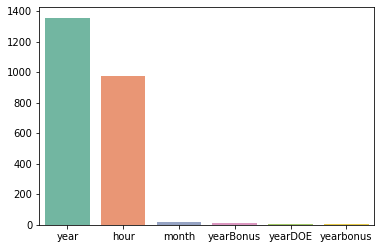

In [47]:
sns.barplot(pd.DataFrame(data_salary_notna.salary_period.value_counts()[:6]).reset_index(), x='index', y='salary_period', palette='Set2').set(xlabel=None, ylabel=None)

The most popular time periods are *year* and *hour*. We can also clean up other time period formats to get more of these periods.

In [48]:
data_salary_notna['salary_period'] = data_salary_notna.salary_period.apply(lambda x: re.sub('year.+', 'year', x) if 
                               x is not np.nan else x)
data_salary_notna['salary'] = data_salary_notna.salary.apply(lambda x: re.sub('year', 'year ', x).lower() if 
                               x is not np.nan else x)

data_salary_notna['salary_period'] = data_salary_notna.salary_period.apply(lambda x: re.sub('hour.+', 'hour', x) if 
                               x is not np.nan else x)
data_salary_notna['salary'] = data_salary_notna.salary.apply(lambda x: re.sub('hour', 'hour ', x).lower() if 
                               x is not np.nan else x)

[Text(0.5, 0, ''), Text(0, 0.5, '')]

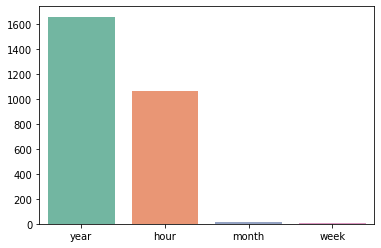

In [49]:
sns.barplot(pd.DataFrame(data_salary_notna.salary_period.value_counts()[:4]).reset_index(), x='index', y='salary_period', palette='Set2').set(xlabel=None, ylabel=None)

Now we have unified time period formats.

### Salary RegEx

A little bit of cleaning up.

In [50]:
# Switch k to thousands (10k $ -> 10,000.00 $)
data_salary_notna['salary'] = data_salary_notna.salary.apply(
    lambda x: re.sub("[0-9](k|K)", 
                     re.search("[0-9](k|K)", x).group()[:-1] + ",000.00", x) 
    if x is not np.nan and re.search("[0-9](k|K)", x) else x)

# Switch per to / (10.00 $ per hour -> 10.00 $ /hour)
data_salary_notna['salary'] = data_salary_notna.salary.apply(lambda x: re.sub("per ", '/', x) if x is not np.nan else x)

Visible formats in the **salary** column are:
* 10.00 - 20.00 &dollar; &sol;hour
* 10,000.00 - 20,000.00 &dollar; &sol;year
* &dollar;10.00 &sol;hour
* &dollar;10,000.00+ &sol;year
* Up to &dollar;20,000.00

Let's write regular exceptions for these formats.

In [51]:
salary_formats = ["10.00 - 20.00 $ /hour", 
                  "10,000.00 - 20,000.00 $ /year",
                  "$10.00+ /hour",  
                  "$10,000.00+ /year", 
                  "Up to $20,000.00",
                  "Others"]

salary_templates = ["[0-9\.]+ - [0-9\.]+( \$)? /hour", 
                    "[0-9\.,]+ - [0-9\.,]+( \$)? /year",
                    "\$?[0-9\.]+\+ /hour",
                    "\$?[0-9\.,]+\+ /year",
                    "Up to \$?[0-9\.,]+"]
salary_counts = []

In [52]:
# 1
format1 = data_salary_notna[data_salary_notna.salary.str.match(salary_templates[0])].salary
salary_counts.append(len(format1))
format1

13                      9.00 - 13.00 $ /hour 
30                     62.00 - 81.00 $ /hour 
43                     15.00 - 16.00 $ /hour 
68       13.75 - 16.75 $ /hour year end bonus
80                     40.00 - 50.00 $ /hour 
                         ...                 
12854                  28.00 - 33.00 $ /hour 
13673                  45.00 - 55.00 $ /hour 
17237                    1.00 - 1.00 $ /hour 
17836                  70.00 - 85.00 $ /hour 
20146                   9.00 - 13.00 $ /hour 
Name: salary, Length: 983, dtype: object

In [53]:
# 2
format2 = data_salary_notna[data_salary_notna.salary.str.match(salary_templates[1])].salary
salary_counts.append(len(format2))
format2

14                          80,000.00 - 95,000.00 $ /year 
19                          60,000.00 - 72,000.00 $ /year 
32                         75,000.00 - 100,000.00 $ /year 
41                          58,000.00 - 65,000.00 $ /year 
61       45,000.00 - 100,000.00 $ /year bonus, benefits...
                               ...                        
18472                     100,000.00 - 145,000.00 $ /year 
19074    50,000.00 - 65,000.00 $ /year bonus (guarantee...
19391        34,000.00 - 42,000.00 $ /year quarterly bonus
20603                      60,000.00 - 120,000.00 $ /year 
21763                      60,000.00 - 120,000.00 $ /year 
Name: salary, Length: 1560, dtype: object

In [54]:
# 3
format3 = data_salary_notna[data_salary_notna.salary.str.match(salary_templates[2])].salary
salary_counts.append(len(format3))
format3.unique()

array(['$10.87+ /hour ', '$12.00+ /hour ', '$16.40+ /hour ',
       '$13.50+ /hour ', '22.00+ /hour ', '$20.00+ /hour ',
       '$13.00+ /hour ', '$15.50+ /hour ', '$11.50+ /hour ',
       '13.00+ /hour ', '$10.00+ /hour ', '$16.00+ /hour ',
       '$15.41+ /hour ', '$10.50+ /hour ', '$24.92+ /hour ',
       '$19.00+ /hour ', '$13.83+ /hour ',
       '$12.00+ /hour annual bonus available', '$18.38+ /hour ',
       '$12.99+ /hour ', '$14.00+ /hour ', '34.00+ /hour ',
       '$14.50+ /hour ', '$10.25+ /hour ', '$15.00+ /hour d.o.e',
       '$11.00+ /hour ',
       '$25.00+ /hour dependent on experience, regular evaluations for raises',
       '$15.00+ /hour ', '$9.50+ /hour ', '$11.52+ /hour ',
       '$8.74+ /hour ', '$16.91+ /hour ', '$15.32+ /hour ',
       '$22.00+ /hour ', '$19.09+ /hour ', '$25.00+ /hour negotiable',
       '$13.00+ /hour production bonus', '16.00+ /hour ',
       '$15.12+ /hour ', '$6.00+ /hour tips', '$9.00+ /hour tips',
       '$12.50+ /hour ', '$10.00+ /hour bo

In [55]:
# 4
format4 = data_salary_notna[data_salary_notna.salary.str.match(salary_templates[3])].salary
salary_counts.append(len(format4))
format4.unique()

array(['$50,000.00+ /year ', '$40,000.00+ /year ',
       '$30,000.00+ /year plus benefits', '45,000.00+ /year ',
       '$120,000.00+ /year ', '$50,000.00+ /year base salary plus bonus',
       '$70,000.00+ /year ', '$84,800.00+ /year relocation',
       '$63,000.00+ /year ', '$50,627.00+ /year ',
       '$60,000.00+ /year competitive benefits package',
       '$60,000.00+ /year high bonus potential and full benefits package',
       '$16.50+ /year ', '$35,000.00+ /year ', '$62,717.00+ /year ',
       '$65,000.00+ /year plus overtime pay and discretionary year-end bonus',
       '$43,640.00+ /year b.o.e.', '215,000.00+ /year ', '$12.00+ /year ',
       '$65,000.00+ /year bonus', '$30,000.00+ /year ',
       '$33,000.00+ /year bonus', '$40,800.00+ /year ',
       '$48,333.00+ /year ', '$33,000.00+ /year ', '$42,167.00+ /year ',
       '$67,500.00+ /year ',
       '$25,000.00+ /year commission, auto allowance, telephone allowance',
       '$51,446.00+ /year ', '$17.50+ /year ', '$85.00+

In [56]:
# 5
format5 = data_salary_notna[data_salary_notna.salary.str.match(salary_templates[4])].salary
salary_counts.append(len(format4))
format5.unique()

array([], dtype=object)

Let's look at the distribution of these formats.

In [57]:
others = data_salary_notna.shape[0] - sum(salary_counts)
salary_counts.append(others)

<AxesSubplot:>

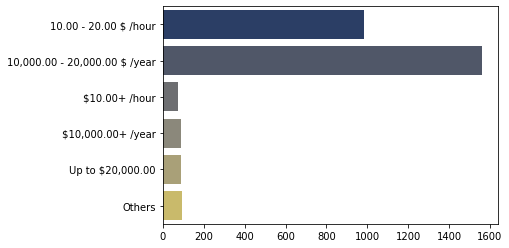

In [58]:
sns.barplot(x = salary_counts, y = salary_formats, orient = 'h', color = salary_counts,  palette = 'cividis')

### Salary numeric value

Some records don't mention the time period. So we'll have to guess it by the amount of money.

In [59]:
# Removing ',' that separates thousands.
data_salary_notna['salary'] = data_salary_notna.salary.apply(lambda x: re.sub(',', '', x) if x is not np.nan else x)

# Extracting numeric value from salary (taking mean for ranges).
salary_value = data_salary_notna.salary.apply(lambda x: np.mean(list(map(float, 
                                                                         re.findall("[0-9]+\.?[0-9]+", x)
                                                                         ))) if x is not np.nan else x)
data_salary_notna.insert(loc=9, column='salary_value', value=salary_value)

Numeric salary size disribution for each time period.

[Text(0.5, 0, 'USD$'), Text(0, 0.5, ''), Text(0.5, 1.0, 'Hourly salary')]

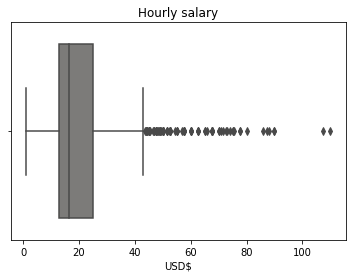

In [60]:
# Ignoring some outliers for clearer vizualization purpose.
data_salary_hour = data_salary_notna[data_salary_notna.salary_period.isin(['hour']) & (data_salary_notna.salary_value < 200)]
sns.boxplot(data = data_salary_hour, x = 'salary_value',  palette = 'cividis').set(xlabel='USD$', ylabel=None, title='Hourly salary')

In [61]:
# Hour
data_salary_notna[data_salary_notna.salary_period == 'hour'].salary_value.describe()

count      1062.00000
mean        911.10245
std       10096.94107
min           1.00000
25%          12.99250
50%          17.00000
75%          25.00000
max      133681.00000
Name: salary_value, dtype: float64

[Text(0.5, 0, 'USD$'),
 Text(0, 0.5, ''),
 Text(0.5, 1.0, 'Weekly and monthly salary')]

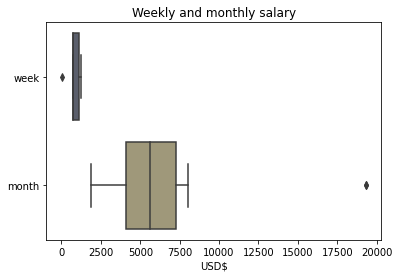

In [62]:
data_salary_weekmonth = data_salary_notna[data_salary_notna.salary_period.isin(['month', 'week'])]
sns.boxplot(data = data_salary_weekmonth, x = 'salary_value', y = 'salary_period',  palette = 'cividis').set(xlabel='USD$', ylabel=None, title='Weekly and monthly salary')

In [63]:
# Week
data_salary_notna[data_salary_notna.salary_period == 'week'].salary_value.describe()

count       5.000000
mean      752.400000
std       480.134148
min        12.000000
25%       700.000000
50%       700.000000
75%      1100.000000
max      1250.000000
Name: salary_value, dtype: float64

In [64]:
data_salary_notna[data_salary_notna.salary_period == 'week'].salary_value

1103     1100.0
8668     1250.0
8909      700.0
9184      700.0
13217      12.0
Name: salary_value, dtype: float64

In [65]:
# Month
data_salary_notna[data_salary_notna.salary_period == 'month'].salary_value.describe()

count       16.000000
mean      6972.256250
std       5115.551819
min       1878.000000
25%       4115.875000
50%       5610.500000
75%       7237.666250
max      19329.970000
Name: salary_value, dtype: float64

In [66]:
data_salary_notna[data_salary_notna.salary_period == 'month'].salary_value

2662     19329.970
2900      3501.775
3300     19329.970
3317      7446.665
3345      5401.860
3622      5742.315
5949      4903.980
12333     2650.000
13554     6883.065
14150     4182.000
14558     7168.000
15189     1878.000
16337     5708.500
17609     5512.500
18109     8000.000
19265     3917.500
Name: salary_value, dtype: float64

[Text(0.5, 0, 'USD$'), Text(0, 0.5, ''), Text(0.5, 1.0, 'Yearly salary')]

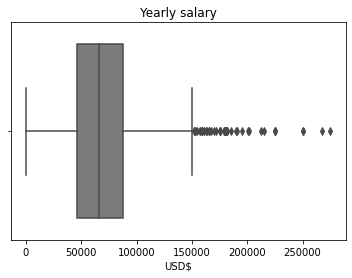

In [67]:
# Ignoring some outliers for clearer vizualization purpose.
data_salary_year = data_salary_notna[data_salary_notna.salary_period.isin(['year']) & (data_salary_notna.salary_value < 300000)]
sns.boxplot(data = data_salary_year, x = 'salary_value',  palette = 'cividis').set(xlabel='USD$', ylabel=None, title='Yearly salary')

In [68]:
# Year
data_salary_notna[data_salary_notna.salary_period == 'year'].salary_value.describe()

count       1662.000000
mean       73069.859695
std        56587.485100
min            0.500000
25%        46000.000000
50%        66683.000000
75%        90000.000000
max      1000000.000000
Name: salary_value, dtype: float64

Considering plots and statistics found for each time period, I came up with these "borderline" values.

In [69]:
# Top value for hourly salary would be 100 (determined visually by plot)
hour_week = 100

# Top value for weekly salary would be the maximum in this category
week_month = data_salary_notna[data_salary_notna.salary_period == 'week'].salary_value.max()

# Top value for monthly salary would be the maximum in this category
month_year = data_salary_notna[data_salary_notna.salary_period == 'month'].salary_value.max()

# Yearly salary would be everything above top monthly salary

In [70]:
def get_period(x):
  if x is np.nan:
    return np.nan

  if x < hour_week:
    return 'hour'
  
  if x < week_month:
    return 'week'
  
  if x < month_year:
    return 'month'

  return 'year'


data_salary_notna['salary_period'] = data_salary_notna.apply(lambda x: get_period(x.salary_value) if x.salary_period not in ('hour', 'week', 'month', 'year') else x.salary_period, axis=1)

### New salary columns

The **salary** column can be split into 5 columns:
1. **salary_range_type** ("from - up to" / "from" / "up to" / NaN)
2. **salary_period** ("year" / "month" / "week" / "hour" etc.)
3. **salary_value_from** - numeric salary value if salary_range_type equals to "from - up to" or "from".
4. **salary_value_upto** - numeric salary value if salary_range_type equals to "from - up to" or "up to".
5. **salary_bonuses** - boolean value, whether bonuses are mentioned in the salary column or not.


In [71]:
def split_salary(x):
  value_from = np.nan
  value_upto = np.nan
  salary_range_type = np.nan
  if re.fullmatch("[0-9\.]+ - [0-9\.]+( \$)? .*", x):
    values = list(map(float, re.findall("[0-9]+\.?[0-9]+", x)))
    value_from = values[0]
    value_upto = values[1]
    salary_range_type = "from - up to"

  if re.fullmatch("\$?[0-9\.]+\+ .*", x):
    value_from = list(map(float, re.findall("[0-9]+\.?[0-9]+", x)))[0]
    salary_range_type = "from"

  if re.fullmatch("Up to \$?[0-9\.,]+", x):
    value_from = list(map(float, re.findall("[0-9]+\.?[0-9]+", x)))[0]
    salary_range_type = "up to"

  return salary_range_type, value_from, value_upto

In [72]:
salary_range_type = data_salary_notna.salary.apply(lambda x: split_salary(x)[0])
salary_value_from = data_salary_notna.salary.apply(lambda x: split_salary(x)[1])
salary_value_upto = data_salary_notna.salary.apply(lambda x: split_salary(x)[2])
salary_bonuses = data_salary_notna.salary.apply(lambda x: bool(re.search("bonus", x)))

data_salary_notna.insert(loc=10, column='salary_range_type', value=salary_range_type)
data_salary_notna.insert(loc=11, column='salary_value_from', value=salary_value_from)
data_salary_notna.insert(loc=12, column='salary_value_upto', value=salary_value_upto)
data_salary_notna.insert(loc=13, column='salary_bonuses', value=salary_bonuses)

In [73]:
data_salary_notna.drop('salary_value', axis=1, inplace=True)
data = pd.concat([data_salary_notna, data_salary_na])
data.drop('salary', axis=1, inplace=True)
data.sample(10)

,job_description,job_title,job_type,city,state,postcode,organization,salary_period,salary_range_type,salary_value_from,salary_value_upto,salary_bonuses,sector
11906,Special Counsel is immediately hiring a Projec...,Project Manager Job in Penn's Park,Full Time Employee,Penns Park,PA,18943,NaN,NaN,NaN,NaN,NaN,NaN,Legal
13014,"Therapist IIlicensed counselor (LCPC, LCSW-C, ...",Therapist II Licensed counselor (LCPC,Full Time,Annapolis Junction,MD,20701,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10022,Hertz Local Edition is seeking professionals t...,Transporter Job in Panama City,Full Time / Employee,Panama City,FL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Manufacturing/Production/Operations
15230,Description You are an experienced Real Estate...,Real Estate Paralegal Job in Seattle,Full Time Employee,Seattle,WA,NaN,Manufacturing - Other,NaN,NaN,NaN,NaN,NaN,Manufacturing/Production/Operations
21423,Retail Sales RepresentativeMen's Wearhouse is ...,Retail Sales Representative Job in Cincinnati,Full Time Employee,Cincinnati,OH,45246,RetailAutomotive Sales and Repair Services,NaN,NaN,NaN,NaN,NaN,Sales/Retail/Business Development
840,The Judge Group is looking for an Oracle Devel...,Oracle Developer Job in Dallas,"Full Time, Employee",Dallas,TX,NaN,Computer/IT Services,NaN,NaN,NaN,NaN,NaN,IT/Software Development
823,Court Security OfficerShared Time PositionRosw...,Court Security Officer (Shared Time Position) ...,Part Time,Roswell,NM,NaN,Government and Military,NaN,NaN,NaN,NaN,NaN,Experienced (Non-Manager)
1210,RESPONSIBILITIES:Kforce has a client that is s...,SharePoint Developer Job in Purchase,"Full Time, Employee",Purchase,NY,10577,NaN,NaN,NaN,NaN,NaN,NaN,Experienced (Non-Manager)
6335,91L Construction Vehicle Repairer Job Descript...,L Construction Vehicle Repairer Job in Wahoo,Full Time Employee,Wahoo,NE,68066,NaN,NaN,NaN,NaN,NaN,NaN,Entry Level
10309,"Ritchie Engineering Company, Inc. is a leading...",Production Line Lead - Hose Department Job in ...,Full Time,Bloomington,MN,55438,Manufacturing - Other,NaN,NaN,NaN,NaN,NaN,NaN


## Job_type

Let's take a look at what type of values there are in the column **job_type**.

In [74]:
data_jobtype_notna = data[data.job_type.notna()]
data_jobtype_na = data[data.job_type.isna()]
data_jobtype_notna.job_type.value_counts()

Full Time                                        6009
Full Time Employee                               5543
Full Time, Employee                              2409
Full Time Temporary/Contract/Project              913
Full Time, Temporary/Contract/Project             445
Full Time , Employee                              305
Part Time Employee                                304
Part Time                                         298
Temporary/Contract/Project                        153
Part Time, Employee                               151
Employee                                          137
Full Time / Employee                              107
Full Time , Temporary/Contract/Project             48
Per Diem, Employee                                 21
Per Diem                                           20
Job Type Full Time Employee                        19
Part Time, Temporary/Contract/Project              19
Part Time/ Temporary/Contract/Project              14
Part Time Seasonal          

A little work with symbols and punctuation marks in order to unify formats.

In [75]:
data_jobtype_notna.job_type = (data_jobtype_notna.job_type.apply(lambda x: re.sub("Job Type ", '', x).strip())
                                                          .apply(lambda x: re.sub("\xa0", ' ', x).strip())
                                                          .apply(lambda x: re.sub(" / ", ', ', x).strip())
                                                          .apply(lambda x: re.sub(" , ", ', ', x).strip())
                                                          .apply(lambda x: re.sub("Part Time/? ", "Part Time, ", x).strip())
                                                          .apply(lambda x: re.sub("Full Time/? ", "Full Time, ", x).strip())
                                                          .apply(lambda x: re.sub("Per Diem/? ", "Per Diem, ", x).strip())
                                                          .apply(lambda x: re.sub("  ", ' ', x).strip()))

In [76]:
data_jobtype_notna.job_type.value_counts()

Full Time, Employee                      8384
Full Time                                6015
Full Time, Temporary/Contract/Project    1409
Part Time, Employee                       463
Part Time                                 299
Temporary/Contract/Project                153
Employee                                  138
Part Time, Temporary/Contract/Project      40
Per Diem, Employee                         32
Per Diem                                   20
Part Time, Seasonal                        12
Full Time, Intern                           5
Part Time, Intern                           3
Per Diem, Temporary/Contract/Project        1
Name: job_type, dtype: int64

Now we have a lot less unique **job_type** values.

We can clearly see that here we have both schedule type and employment type in one column. Let's break it into two columns.

In [77]:
def split_job_type(x):
  schedule_type = 'Full Time'
  employment_type = 'Employee'
  values = x.split(', ')
  if len(values) == 1:
    if values[0] in ('Full Time', 'Part Time', 'Par Diem'):
      schedule_type = values[0]
    else:
      employment_type = values[0]
  else:
    schedule_type = values[0]
    employment_type = values[1]
  return schedule_type, employment_type
    

schedule_type = data_jobtype_notna.job_type.apply(lambda x: split_job_type(x)[0])
employment_type = data_jobtype_notna.job_type.apply(lambda x: split_job_type(x)[1])

data_jobtype_notna.insert(loc=2, column='schedule_type', value=schedule_type)
data_jobtype_notna.insert(loc=3, column='employment_type', value=employment_type)


data_jobtype_na.insert(loc=2, column='schedule_type', value="Full Time")
data_jobtype_na.insert(loc=3, column='employment_type', value="Employee")

In [78]:
data = pd.concat([data_jobtype_notna, data_jobtype_na])
data.drop('job_type', axis=1, inplace=True)
data.sample(10)

,job_description,job_title,schedule_type,employment_type,city,state,postcode,organization,salary_period,salary_range_type,salary_value_from,salary_value_upto,salary_bonuses,sector
19448,Critical Care RN Registered Nurse - Travel to ...,Critical Care RN Registered Nurse - Travel to ...,Full Time,Temporary/Contract/Project,New York City,NY,10029,NaN,NaN,NaN,NaN,NaN,NaN,Medical/Health
17757,Check out the following fantastic career oppor...,Implementation Manager I Job in Irving,Full Time,Employee,Irving,TX,NaN,Healthcare Services,NaN,NaN,NaN,NaN,NaN,NaN
5714,Legal Billing Clerk Special Counsel is hiring ...,Temporary Legal Billing Clerk Job in Philadelphia,Full Time,Temporary/Contract/Project,Philadelphia,PA,19103,NaN,NaN,NaN,NaN,NaN,NaN,Legal
20741,City:Savannah State:Georgia Postal/Zip Code:31...,Quality Control Lab Technician - Savannah,Full Time,Employee,Savannah,GA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10884,"Staff Accountant Job in San Diego, CA Are you...",Staff Accountant Job in San Diego,Full Time,Temporary/Contract/Project,San Diego,CA,92123,NaN,NaN,NaN,NaN,NaN,NaN,Accounting/Finance/Insurance
11812,Job Title: Production Systems Technician Area ...,Production Systems Technician Job in San Jose,Full Time,Employee,San Jose,CA,NaN,Computer Hardware,NaN,NaN,NaN,NaN,NaN,NaN
17816,Custom Care Home Health & Hospice is seeking a...,Certified Nursing Assistant for Home Health & ...,Full Time,Employee,Dallas,TX,75240,All,NaN,NaN,NaN,NaN,NaN,Experienced (Non-Manager)
5872,Stellar corporate opportunity with a top AmLaw...,Stellar Opportunity for Mid-Level M&A Attorney...,Full Time,Employee,New York,NY,10112,NaN,NaN,NaN,NaN,NaN,NaN,Legal
16920,ENTRY LEVEL - Marketing / Advertising / Public...,ENTRY LEVEL Openings-Immediate Hire / FULL PAI...,Full Time,Employee,Little Rock,AR,72211,RetailAdvertising and PR ServicesOther/Not Cla...,NaN,NaN,NaN,NaN,NaN,Customer Support/Client Care
4587,"Do you find yourself asking this question?""Ho...",Event Team Hiring : Customer Service / Marketi...,Full Time,Employee,Renton,WA,98057,Advertising and PR Services Entertainment Venu...,NaN,NaN,NaN,NaN,NaN,Project/Program Management


## Job_title

**job_title** column values frequently follow the pattern "[Job name] Job In [City]".

In [79]:
# Converting to the title case.
data.job_title = data.job_title.apply(lambda x: ' '.join(map(lambda y: y.capitalize(), x.split())))
indx = data.job_title.apply(lambda x: bool(re.search('Job', x)))
data[indx].job_title.value_counts()

Staff Accountant Job In Dallas                                   17
Senior Accountant Job In Dallas                                  13
Sales Representative Job In Dallas                                7
Customer Service Representative Job In Dallas                     6
Retail Sales Associate Job In Cincinnati                          6
                                                                 ..
Attorney - Real Estate Litigation (ny Barred) Job In New York     1
Military Health Systems Paralegal Job In Aurora                   1
Associate Attorney Job In Middletown                              1
Commercial Real Estate Attorney Job In Garden City                1
Production Supervisor Rd Shift Job In Arcadia                     1
Name: job_title, Length: 16163, dtype: int64

We can get rid of the "... Job In [City]" part to get only the pure job title (so that same jobs in different cities would have same values in job_title column).

In [80]:
data.job_title = data.job_title.apply(lambda x: re.sub('Job.*', '', x))
data.job_title.value_counts()

Cybercoders                                            236
Project Manager                                        130
N Horizontal Construction Engineers                    104
L Construction Vehicle Repairer                         87
Restaurant Manager                                      86
                                                      ... 
Registered Surveyor                                      1
Deskside / Tier Ii/iii Implementation /support           1
Project Staff Accountant                                 1
Infrastructure Project Manager - Columbus Oh             1
Career Management Consultant- Project - Cincinnatti      1
Name: job_title, Length: 12153, dtype: int64

Some entries have dash-separated values that are supposed to be in other columns, but they follow no particular order, so it would be hard to distribute them between those columns.

In [81]:
indx = data.job_title.apply(lambda x: bool(re.search(' - ', x)))
data[indx].job_title.value_counts()

B Combat Engineer - Construction And Engineering Specialist      85
Aflac - Benefits Sales Consultant                                32
Residential Lawn Specialist -                                    18
Manufacturing – Change Career To - Truck Driver – Entry Level    16
Class A Cdl Driver - Tsc                                         12
                                                                 ..
Director Of Med Mgmt - Rn Registered Nurse (full Time/ Hrs)       1
Instructor - Full Time - Cosmetology                              1
Commercial Operations Manager (r&e) - Houston                     1
Associate Sales Consultant - Knoxville                            1
Career Management Consultant- Project - Cincinnatti               1
Name: job_title, Length: 2742, dtype: int64

## Organization

In [82]:
data_org_notna = data[data.organization.notna()]
data_org_na = data[data.organization.isna()]
data_org_notna.organization.value_counts()

Healthcare Services                                                            1439
All                                                                             983
Other/Not Classified                                                            911
Manufacturing - Other                                                           766
Computer/IT Services                                                            656
                                                                               ... 
City Of Industry, CA 91744                                                        1
Travel, Transportation and Tourism Healthcare Services Other/Not Classified       1
Computer SoftwareBusiness Services - Other                                        1
Computer/IT ServicesOther/Not Classified                                          1
Arcadia, WI 54612                                                                 1
Name: organization, Length: 653, dtype: int64

Values like "All", "Other", "Not Classified" are not senseless and can be deleted.

In [83]:
data_org_notna.organization = ( data_org_notna.organization.apply(lambda x: re.sub("( - )|;", '; ', x).strip())
                                                           .apply(lambda x: re.sub("(All)|(Other)", '', x).strip())
                                                           .apply(lambda x: re.sub("/Not Classified", '', x).strip())
                                                           .apply(lambda x: re.sub('&', 'and', x).strip()))

In [84]:
# Some words have stuck to each other (e.g. RetailAdvertising). We need to separate them.
def split_borders(x):
  borders = re.findall("[a-z][A-Z]", x)
  for i, pair in enumerate(borders):
    x = re.sub("[a-z][A-Z]", borders[i][0]+'; '+borders[i][1], x, count=1)
  return x

data_org_notna.organization = ( data_org_notna.organization.apply(lambda x: split_borders(x))
                                              .apply(lambda x: re.sub("Services(?!;|$)", "Services;", x))
                                              .apply(lambda x: re.sub(";$", '', x))
                                              .apply(lambda x: np.nan if not x else x) )

In [85]:
# Removing organization column values that are actually locations.
def org_is_location(x):
  for val in re.sub(",", '', x.organization).split():
    if (val == x.city) or (val == x.state) or (val == x.postcode):
      return True
  return False

data_org_notna.organization = data_org_notna.apply(lambda x: np.nan if (x.organization is np.nan) or  org_is_location(x) else x.organization, axis=1)

In [86]:
data_org_notna.sample(15).organization

6566     Construction; Industrial Facilities and Infras...
20657                                               Retail
6582                                                   NaN
4956                    Travel, Transportation and Tourism
7928     Advertising and PR Services; Staffing/Employme...
13260                                        Manufacturing
6272                      Accounting and Auditing Services
14384                                                  NaN
19379                         Staffing/Employment Agencies
6752                              Restaurant/Food Services
17306                                                  NaN
14204                                            Insurance
4530                         Biotechnology/Pharmaceuticals
11086                                 Computer/IT Services
5190     Construction; Industrial Facilities and Infras...
Name: organization, dtype: object

In [87]:
data = pd.concat([data_org_notna, data_org_na])

## Sector

In [88]:
data_sector_notna = data[data.sector.notna()]
data_sector_na = data[data.sector.isna()]
data_sector_notna.sector.value_counts()

Experienced (Non-Manager)                                                                                           3870
Entry Level                                                                                                         1011
Medical/Health                                                                                                       930
Manager (Manager/Supervisor of Staff)                                                                                811
Sales/Retail/Business Development                                                                                    762
                                                                                                                    ... 
Equipment Install/Maintain/RepairFacilities Management/MaintenanceGeneral/Other: Installation/Maintenance/Repair       1
Real Estate Leasing/Acquisition                                                                                        1
Occupational Health and Safety  

In [89]:
# Removing useless generic words like General/Other and separating stuck-together words (e.g. DevelopmentFinancial)
data_sector_notna.sector = ( data_sector_notna.sector.apply(lambda x: re.sub("(General/Other: )|(Other)|(, etc)", '', x).strip()) 
                                               .apply(lambda x: split_borders(x))
                                               .apply(lambda x: np.nan if not x else x) )

In [90]:
data_sector_notna.sample(7)

,job_description,job_title,schedule_type,employment_type,city,state,postcode,organization,salary_period,salary_range_type,salary_value_from,salary_value_upto,salary_bonuses,sector
16091,Job Description:SUMMARY: Responsible for recei...,Switchboard Operator,Full Time,Temporary/Contract/Project,Cincinnati,OH,45206,NaN,NaN,NaN,NaN,NaN,NaN,Experienced (Non-Manager)
16459,Vault Clerk opportunity in Dallas with leading...,Vault Clerk (day Shift) Opportunity In Dallas ...,Full Time,Temporary/Contract/Project,Dallas,TX,75212,NaN,NaN,NaN,NaN,NaN,NaN,Customer Support/Client Care
5285,Weinstock Immigration Lawyers - Dunwoody Locat...,Immigration Paralegal / Immigration Specialist,Full Time,Employee,Dunwoody,GA,30338,Legal Services,NaN,NaN,NaN,NaN,NaN,Experienced (Non-Manager)
14767,Kforce is one of the premier leaders in the st...,Talent Management Analyst,Full Time,Employee,Tampa,FL,33605,NaN,NaN,NaN,NaN,NaN,NaN,Experienced (Non-Manager)
4230,UPS Supply Chain Solutions is seeking a Soluti...,Ups Solutions Coordinator,Full Time,Employee,Overland Park,KS,66210,Transport and Storage; Materials,NaN,NaN,NaN,NaN,NaN,Customer Support/Client Care
5223,Monarch Investment is seeking a Maintenance Te...,Apartment Maintenance Technician,Full Time,Employee,Columbus,OH,NaN,Real Estate/Property Management,hour,from - up to,14.0,17.0,True,Experienced (Non-Manager)
18649,Health Imperatives is seeking an experienced N...,Nurse Practitioner,Full Time,Employee,Westfield,MA,01086,Nonprofit Charitable Organizations,hour,from - up to,48.0,49.0,False,Experienced (Non-Manager)


In [91]:
data = pd.concat([data_sector_notna, data_sector_na])

# Result and final thoughts

Here is the cleaned-up dataset.

In [92]:
data.sample(10)

,job_description,job_title,schedule_type,employment_type,city,state,postcode,organization,salary_period,salary_range_type,salary_value_from,salary_value_upto,salary_bonuses,sector
18995,To eat. To laugh. To share. That’s why people ...,Pizza Hut - Assistant Manager Kaukauna,Full Time,Employee,Kaukauna,WI,54130,Restaurant/Food Services,NaN,NaN,NaN,NaN,NaN,Food Services/Hospitality
1108,« back Learn More DBA - AM03 Job #: 668982Ape...,Dba - Am,Full Time,Employee,Dallas,TX,NaN,Computer/IT Services,NaN,NaN,NaN,NaN,NaN,Experienced (Non-Manager)
21542,Summary Brand Ambassador Sales part Time We ...,Brand Ambassador Sales Part Time,Part Time,Employee,Cincinnati,OH,NaN,Retail,NaN,NaN,NaN,NaN,NaN,Sales/Retail/Business Development
18712,Assistant Restaurant Manager/Director Big Lea...,Assistant Restaurant Manager / Food & Beverage...,Full Time,Employee,Manteca,CA,95337,Sports and Physical Recreation,NaN,NaN,NaN,NaN,NaN,Manager (Manager/Supervisor of Staff)
2363,"Financial Analyst Job in New York City, NYC Fo...",Staff Accountant,Full Time,Employee,New York,NY,10017,NaN,year,from - up to,65000.0,75000.0,False,Accounting/Finance/Insurance
18904,Nurse Practitioner - OncologySan Francisco Bay...,Nurse Practitioner – Oncology,Full Time,Employee,San Francisco,CA,NaN,Healthcare Services,year,from - up to,130000.0,165000.0,False,Medical/Health
12019,Prodigy Placements is recruiting for a Talent ...,Recruiting Coordinator,Full Time,Employee,Chicago,IL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8230,Overview: A major public company specializing ...,Senior Attorney Editor - Federal Government Co...,Full Time,Temporary/Contract/Project,Washington Dc,DC,20036,Legal Services,NaN,NaN,NaN,NaN,NaN,Legal
4324,Get your CDL-A in ONLY 21-days. CR England off...,Truck Drivers - No Cdl? No Problem! We Train,Full Time,Employee,Faxon Hills,OH,NaN,Transport and Storage; Materials,NaN,NaN,NaN,NaN,NaN,Logistics/Transportation
18106,"Senior Web DeveloperLocation: Plano, TXContrac...",Sr. Web Developer,Full Time,Employee,Dallas,TX,75204,Computer Software,NaN,NaN,NaN,NaN,NaN,NaN


In [93]:
data.to_csv("monster_com-job_cleaned.csv")

## Before/after

In [94]:
print(f"Initial dataset size: {data_copy.shape[0]} rows, {data_copy.shape[1]} columns")
print(f"Resulting dataset size: {data.shape[0]} rows, {data.shape[1]} columns")

Initial dataset size: 22000 rows, 14 columns
Resulting dataset size: 18238 rows, 14 columns


Statistics for each column.

In [95]:
# BEFORE
data_copy.describe()

,country,country_code,date_added,has_expired,job_board,job_description,job_title,job_type,location,organization,page_url,salary,sector,uniq_id
count,22000,22000,122,22000,22000,22000,22000,20372,22000,15133,22000,3446,16806,22000
unique,1,1,78,1,1,18744,18759,39,8423,738,22000,1737,163,22000
top,United States of America,US,9/22/2016,No,jobs.monster.com,12N Horizontal Construction Engineers Job Desc...,Monster,Full Time,"Dallas, TX",Healthcare Services,http://jobview.monster.com/it-support-technici...,"40,000.00 - 100,000.00 $ /year",Experienced (Non-Manager),11d599f229a80023d2f40e7c52cd941e
freq,22000,22000,6,22000,22000,104,318,6757,646,1919,1,50,4594,1


In [96]:
# AFTER (text fields)
data.describe(include=[np.object])

,job_description,job_title,schedule_type,employment_type,city,state,postcode,organization,salary_period,salary_range_type,salary_bonuses,sector
count,18238,18238,18238,18238,17130,17056,11113,10238,2890,2741,2890,14115
unique,16298,12153,3,5,2733,62,4316,409,4,2,2,149
top,12N Horizontal Construction Engineers Job Desc...,Cybercoders,Full Time,Employee,Dallas,TX,75201,Healthcare Services,year,from - up to,False,Experienced (Non-Manager)
freq,93,236,17388,16595,1246,2715,278,1537,1740,2575,2693,3870


In [97]:
# AFTER (numeric fields)
data.describe(include=[np.number])

,salary_value_from,salary_value_upto
count,2741.000000,2575.000000
mean,35533.743543,52095.129650
std,44654.294638,76721.311625
min,0.000000,1.000000
25%,16.000000,22.465000
50%,35000.000000,50000.000000
75%,60000.000000,85000.000000
max,1000000.000000,1000000.000000


Renewed dataset aquired two numeric columns. Columns that are same for both versions of the dataset now have less unique values, not only because of dropping some rows, but also because of formatting and standartization. Also due to the splitting of **location**, **salary** and **job_type** into multiple columns, now it is much easier to filter, sort and aggregate data.

Let's take a look at missing values.




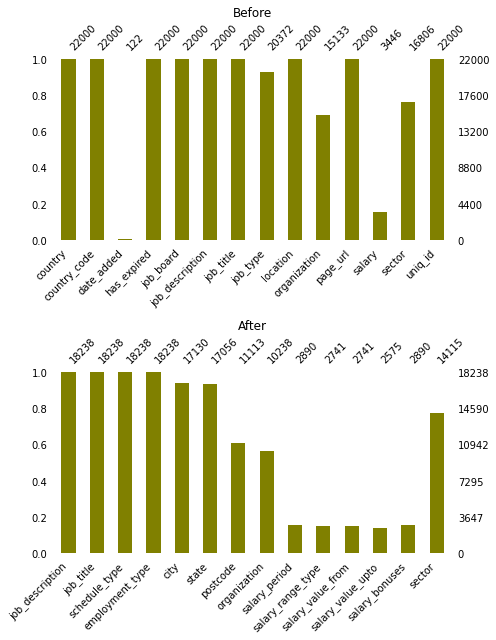

In [98]:
fig, axes = plt.subplots(2, figsize=(7, 9))
axes[0].set_title("Before")
axes[1].set_title(f"After")
msno.bar(data_copy, color="olive", ax=axes[0], fontsize=10)
msno.bar(data, color="olive", ax=axes[1], fontsize=10)
fig.tight_layout()

- There are many missing values in 5 columns, which resulted from splitting the **salary** column, that initially had a lot of NaNs. 
- Column **organization** now has a little bit larger share of NaNs because of deleting irrelevant data and moving some values to the **location** column. 
- Among newly added location-related columns **postcode** has more missing values. Looks like postcode is more rarely mentioned than city and/or state.

## Next steps

- **job_description** column has a lot of valuable information that can be used to fill other columns. Nevertheless, this information is stored in large unstructured texts and their processing is not a trivial tasks. Some NLP methods can come in handy here.

- In **job_title** column some records contain 'rubbish' words, which doesn't relate to the job title. They cannot be determined exclusively by format, some form of semantic analysis is needed.

- Column **sector** can potentially be divided into working field and required level. As for now, there are very few records that contain both types, therefore splitting would result in many NaNs.

- Columns **organization** and **sector** a majority of records are a set of multiple values. For these records to be included when grouping by single unique values, these sets need to be split up using one-hot encoding. However this method requires that ranges of values are limited.